# 03/11/24 - Debugging the JAM method with spherical geometry and with OM anisotropy.
# 03/18/24 - Picking up with OM.
# 03/20/24 - Back to the drawing board because the plotting isn't working correctly
______________________
### 02/22/24 - Adding covariance matrix to the space_jam method
### 02/12/24 - Adding least squares fitting option to forgo the time consuming MCMC for testing purposes.
### 12/26/23 - This notebook tests the modules "space_jam" and "total_mass_mge" in e.g. home/shawnknabel/Documents/slacs_kinematics/my_python_packages/space_jam.py

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
#plt.switch_backend('agg')
%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
#import pickle
import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
#from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


In [2]:
# bring in the space_jam and total_mass_mge modules

from space_jam import space_jam
from total_mass_mge import total_mass_mge

In [3]:
##################################################################################################################################

old_date_of_kin = '2023-02-28_2'
date_of_kin = '2024_02_15'

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
old_kinematics_dir = f'{kinematics_full_dir}{old_date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

# target SN for voronoi binning
vorbin_SN_targets = np.array([10, 15, 20])

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')

# 03/11/24 - Spherical Geometry is not working. Here, I am going to debug. 
## There are only 5 parameters. Let's roll.
## Use lsq minimization

In [8]:
%matplotlib inline

In [9]:
'''
Run spherical geometry
'''

def space_jam_sph(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='const'
    geometry='sph'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    # gamma0, einstein radius, anis, k_mst, a_mst
    p0 =      [2.0,  1.0,  0.9,   0.5,   7] 
    bounds = [[1.4,  0.7,  0.0,   0.0,   5 ], 
              [2.8,  2.0,  1.0,   1.0,   10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1000
    nwalkers = 12
    ndim = 5
    minimization = 'lsq'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
    run_id = 1

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                     obj_name, mass_model, anisotropy, geometry, align, 
                                    zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    welcome_to_the_jam.fit_lsq()
    welcome_to_the_jam.summary_plot()
    #welcome_to_the_jam.save_space_jam()

# Run it on J0029 index 0

In [6]:
space_jam_sph(0)

Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/SDSSJ0029-0055_2024_03_20_v1/ will be overwritten.

JAM Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ0029-0055/SDSSJ0029-0055_2024_03_20_v1/

[0.0193628  0.1271433  0.245625   0.62405075 1.096469   1.30303874
 2.41793371 4.86902665 4.86902665] [0.80435509 0.8        0.80871018 0.82702924 0.8        0.9
 0.8        0.8        0.9       ]
Parameters are  ['$\\gamma$', '$\\theta_E$', '$\\sigma_{\\theta}/\\sigma_r$', '$\\lambda_{int}$', '$a_{MST}$']
Priors are now  ['uniform', 'uniform', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 1.0, 0.9, 0.5, 7]
Added 5.0% systematics to diagonal.
Covariance terms are 2.0%.
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change 

KeyboardInterrupt: 

# Now MCMC

In [ ]:
'''
Run spherical geometry
'''

def space_jam_sph(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='const'
    geometry='sph'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    # gamma0, einstein radius, anis, k_mst, a_mst
    p0 =      [2.0,  1.0,  0.9,   0.5,   7] 
    bounds = [[1.4,  0.7,  0.0,   0.0,   5 ], 
              [2.8,  2.0,  1.0,   1.0,   10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1
    nwalkers = 12
    ndim = 5
    minimization = 'MCMC'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
    run_id = 1

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                     obj_name, mass_model, anisotropy, geometry, align, 
                                    zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    #welcome_to_the_jam.fit_lsq()
    welcome_to_the_jam.run_mcmc()
    welcome_to_the_jam.summary_plot()
    #welcome_to_the_jam.save_space_jam()

In [ ]:
space_jam_sph(0)

In [ ]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
#plt.switch_backend('agg')
#%matplotlib inline
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
from pathlib import Path
import pickle
#import dill as pickle
from datetime import datetime
def tick():
    return datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
import glob

# astronomy/scipy
from astropy.io import fits
#from astropy.wcs import WCS
#from scipy.ndimage import rotate
#from scipy.ndimage import map_coordinates
#from scipy.optimize import least_squares as lsq
#from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
#from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
#from scipy.interpolate import interp1d
#from scipy.optimize import fsolve
import astropy.units as u
import astropy.constants as constants

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")


################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# value of c^2 / 4 pi G
c2_4piG = (constants.c **2 / constants.G / 4 / np.pi).to('solMass/pc')


########################################################

# bring in the space_jam and total_mass_mge modules

from space_jam import space_jam
from total_mass_mge import total_mass_mge

#########################################################

##################################################################################################################################

date_of_kin = '2024_02_15'

# set today's datetime
date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
jam_output_dir = f'{data_dir}jam_outputs/'
# create a directory for JAM outputs
#Path(jam_output_dir).mkdir(parents=True, exist_ok=True)
#print(f'Outputs will be in {jam_output_dir}')
print()

#################################################
# objects
obj_names = ['SDSSJ0029-0055', 
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################

paper_table = pd.read_csv(f'{tables_dir}paper_table_100223.csv')
slacs_ix_table = pd.read_csv(f'{tables_dir}slacs_ix_table3.csv')
zs = paper_table['zlens']
zlenses = slacs_ix_table['z_lens']
zsources = slacs_ix_table['z_src']
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')

#############################################################################

# define the tasks

'''
First task is spherical constant
'''

def task_1(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='const'
    geometry='sph'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    # gamma0, einstein radius, anis, k_mst, a_mst
    p0 =      [2.0,  1.0,  0.9,   0.5,   7] 
    bounds = [[1.4,  0.7,  0.0,   0.0,   5 ], 
              [2.8,  2.0,  1.0,   1.0,   10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1
    nwalkers = 12
    ndim = 5
    burn = 0
    minimization = 'MCMC'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    run_id = 1

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                   obj_name, mass_model, anisotropy, geometry, align, 
                                   zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, 
                                   fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, 
                                   date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    welcome_to_the_jam.run_mcmc()
    welcome_to_the_jam.save_space_jam()
    welcome_to_the_jam.summary_plot(save=True, burn=burn)
    
'''
Second task is axisymmetric cylindrical
'''

def task_2(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='OM'
    geometry='sph'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    # gamma0, einstein radius, anis, k_mst, a_mst
    p0 =      [2.0,  1.0,  0.7,   0.5,   7] 
    bounds = [[1.4,  0.7,  0.01,  0.0,   5 ], 
              [2.8,  2.0,  4.0,   1.0,   10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1
    nwalkers = 12
    ndim = 5
    burn = 0
    minimization = 'MCMC'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    run_id = 2

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                   obj_name, mass_model, anisotropy, geometry, align, 
                                   zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, 
                                   fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, 
                                   date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    welcome_to_the_jam.run_mcmc()
    welcome_to_the_jam.save_space_jam()
    welcome_to_the_jam.summary_plot(save=True, burn=burn)
    
# protect the entry point
from concurrent.futures import ProcessPoolExecutor

if __name__ == '__main__':
    # report a message
    print('Starting task 1...')
    # create the process pool
    with ProcessPoolExecutor(1) as exe:
        # perform calculations
        results = exe.map(task_1, range(1))
    # report a message
    print('Done.')
    
if __name__ == '__main__':
    # report a message
    print('Starting task 2...')
    # create the process pool
    with ProcessPoolExecutor(1) as exe:
        # perform calculations
        results = exe.map(task_2, range(1))
    # report a message
    print('Done.')

# Now OM

In [ ]:
'''
Run spherical geometry
'''

def space_jam_sph_OM(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='OM'
    geometry='sph'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    # gamma0, einstein radius, anis, k_mst, a_mst
    p0 =      [2.0,  1.0,  0.7,   0.5,   7] 
    bounds = [[1.4,  0.7,  0.01,   0.0,   5 ], 
              [2.8,  2.0,  4.0,   1.0,   10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1000
    nwalkers = 12
    ndim = 5
    minimization = 'lsq'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    date_time = datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
    run_id = 1

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                     obj_name, mass_model, anisotropy, geometry, align, 
                                    zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    welcome_to_the_jam.fit_lsq()
    #welcome_to_the_jam.summary_plot()
    #welcome_to_the_jam.save_space_jam()

In [ ]:
space_jam_sph_OM(0)

________________________________
# 03/20/24 - Also looking at why the axisymmetric models failed for J1250 and J1306
from 031924_jam_axi_cyl_and_sph_j1250_j1306.py

In [5]:
%matplotlib inline

In [4]:
# define the tasks

'''
First task is axisymmetric spherical
'''

i=5

obj_name = obj_names[i]
kin_dir = f'{kinematics_dir}{obj_name}/'
jam_dir = f'{jam_output_dir}{obj_name}/'
jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='sph'
zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
#cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
systematics_est = 0.05 # %
covariance_est = 0.02 # %
p0 =      [2.0,  1.0,  0.4,    0.9,   0.5,  7] # gamma0, einstein radius, q0, k_ani, k_mst, a_mst
bounds = [[1.4,  0.7,  0.051,  0.0,   0.0,  5 ], 
          [2.8,  2.0,  1.0,    1.0,   1.0,  10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
fix_pars = [0, 0, 0, 0, 1, 1]
lambda_int= 1.0
nstep = 1
nwalkers = 12
ndim = 6
minimization = 'lsq'
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = '2024_03_11'#datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 1

welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                 obj_name, mass_model, anisotropy, geometry, align, 
                                zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                               systematics_est=systematics_est, covariance_est=covariance_est,
                               p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                               minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)

welcome_to_the_jam.fit_lsq()
#welcome_to_the_jam.run_mcmc()
#welcome_to_the_jam.save_space_jam()
 

Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1250+0523/SDSSJ1250+0523_2024_03_11_v1/ will be overwritten.

JAM Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1250+0523/SDSSJ1250+0523_2024_03_11_v1/

Giving the qs a little nudge
Parameters are  ['$\\gamma$', '$\\theta_E$', '$q_{\\rm intr}$', '$\\sigma_{\\theta}/\\sigma_r$', '$\\lambda_{int}$', '$a_{MST}$']
Priors are now  ['uniform', 'uniform', 'gaussian', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 1.0, 0.74, 0.9, 0.5, 7]
Added 5.0% systematics to diagonal.
Covariance terms are 2.0%.
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

St

/home/shawnknabel/.local/lib/python3.11/site-packages/jampy/jam_axi_proj.py:1018: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.clf()


Files in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1306+0600/SDSSJ1306+0600_2024_03_11_v1/ will be overwritten.

JAM Outputs to  /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1306+0600/SDSSJ1306+0600_2024_03_11_v1/

Giving the qs a little nudge
Parameters are  ['$\\gamma$', '$\\theta_E$', '$q_{\\rm intr}$', '$\\sigma_{\\theta}/\\sigma_r$', '$\\lambda_{int}$', '$a_{MST}$']
Priors are now  ['uniform', 'uniform', 'gaussian', 'uniform', 'uniform', 'uniform']
Mean prior values are  [2.0, 1.0, 0.74, 0.9, 0.5, 7]
Added 5.0% systematics to diagonal.
Covariance terms are 2.0%.
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`

St

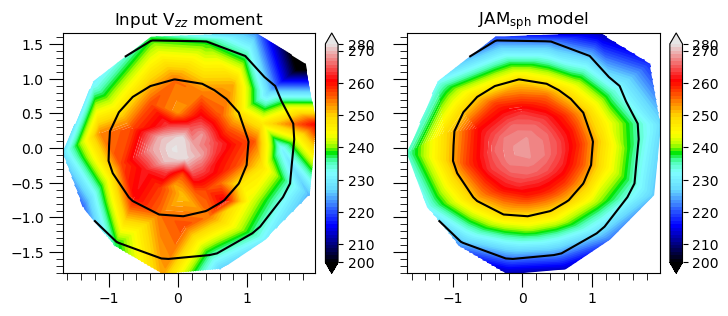

In [16]:
# define the tasks

'''
First task is axisymmetric spherical
'''

i=6

obj_name = obj_names[i]
kin_dir = f'{kinematics_dir}{obj_name}/'
jam_dir = f'{jam_output_dir}{obj_name}/'
jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
mass_model='power_law'
anisotropy='const'
geometry='axi'
align='sph'
zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
#cosmo = cosmo
fast_slow = paper_table.loc[0, 'class_for_JAM_models']
systematics_est = 0.05 # %
covariance_est = 0.02 # %
p0 =      [2.0,  1.0,  0.4,    0.9,   0.5,  7] # gamma0, einstein radius, q0, k_ani, k_mst, a_mst
bounds = [[1.4,  0.7,  0.051,  0.0,   0.0,  5 ], 
          [2.8,  2.0,  1.0,    1.0,   1.0,  10]]
sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
lensprior = False
fix_pars = [0, 0, 0, 0, 1, 1]
lambda_int= 1.0
nstep = 1
nwalkers = 12
ndim = 6
minimization = 'lsq'
sampler_args = [nstep, nwalkers, ndim] # 10 walkers
date_time = '2024_03_11'#datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
run_id = 1

welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                 obj_name, mass_model, anisotropy, geometry, align, 
                                zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                               systematics_est=systematics_est, covariance_est=covariance_est,
                               p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                               minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                               test_prior=False, constant_err=False, kinmap_test=None)

welcome_to_the_jam.fit_lsq()

#welcome_to_the_jam.save_space_jam()
 

In [17]:
welcome_to_the_jam.run_mcmc()

Started Emcee please wait...
Progress is printed periodically
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


  0%|                                                              | 0/1 [00:00<?, ?it/s]

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


100%|██████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/it]

n accepted unique parameters 12
Saving to /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/jam_outputs/SDSSJ1306+0600/SDSSJ1306+0600_2024_03_11_v1/SDSSJ1306+0600_2024_03_11_v1_space_jam.pkl
Job's finished!


In [ ]:
welcome_to_the_jam.summary_plot

In [7]:
# squash

In [8]:
welcome_to_the_jam.qobs_lum

array([0.95      , 0.94275743, 0.93146436, 0.92979804, 0.8       ,
       0.8       ])

In [9]:
welcome_to_the_jam.bounds

[[1.4, 0.7, 0.7706801642992446, 0.0, 0.0, 5],
 [2.8, 2.0, 0.9234479623725592, 1.0, 1.0, 10]]

In [10]:
welcome_to_the_jam.qobs_eff

0.9234479623725592

In [11]:
# I get the lower bound on shape from my inclination restictions

In [12]:
inc = welcome_to_the_jam.calculate_inclination_from_qintr_eff(welcome_to_the_jam.bounds[0][2])
inc

37.02632789936134

In [13]:
inc = np.radians(inc)
qmin = 0.05
np.sqrt(np.cos(inc)**2 + (qmin*np.sin(inc))**2)

0.7989264481433506

In [14]:
# calculate the inclination
y = (1 - welcome_to_the_jam.qobs_eff**2)/(1 - welcome_to_the_jam.bounds[0][2]**2) # sin^2(inclination)
inc = 180/np.pi*np.arcsin(np.sqrt(y))
print(inc)


37.02632789936134


In [15]:
# calculate the q_obs_min
qmin = 0.05 # let minimum deprojected q_intr be 0.05 (as in jampy)
np.sqrt(np.cos(inc)**2 + (qmin*np.sin(inc))**2)

0.7827102641012038

In [11]:
np.all(welcome_to_the_jam.qobs_lum >= np.sqrt(np.cos(inc)**2 + (qmin*np.sin(inc))**2))

False

In [12]:
(1+0.05**2)

1.0025

In [13]:
qbound_poop = np.sqrt( (welcome_to_the_jam.qobs_eff**2 - (0.8)**2)/(1 - (0.8)**2))
qbound_poop

0.7687582686276753

In [14]:
qbound_poop * (1+0.05**2)

0.7706801642992445

In [35]:
inc = welcome_to_the_jam.calculate_inclination_from_qintr_eff(welcome_to_the_jam.bounds[0][2]*(1+0.05**2))
inc = np.radians(inc)
qmin = 0.05
inc = np.sqrt(inc**2)
np.sqrt(np.cos(inc)**2 + (qmin*np.sin(inc))**2)

0.7989264481433506

# Wait, have I been calculating inclination incorrectly this whole time?

In [22]:
def calculate_inclination_from_qintr_eff (self, qintr_eff):#, x_bound_hi ):

        #f = lambda x: np.sqrt( (qobs_eff**2 - x)/(1 - x) ) - q_intr
        #xx = fsolve(f, x_bound_hi)[0]

        y = (1 - self.qobs_eff**2)/(1 - qintr_eff**2) # sin^2(inclination)
        inclination = 180/np.pi*np.arcsin(np.sqrt(y))

        return inclination

# No, it's fine! I added the term (welcome_to_the_jam.bounds[0][1]*(1+qmin**2)) to space_jam.py

In [56]:
welcome_to_the_jam.bounds

[[1.4, 0.7194924387425982, 0.7687582686276754, 0.0, 0.0, 5],
 [2.8, 2.0, 0.9234479623725592, 1.0, 1.0, 10]]

In [3]:
welcome_to_the_jam.fit_lsq()

NameError: name 'welcome_to_the_jam' is not defined

In [ ]:
welcome_to_the_jam.bounds

In [ ]:
welcome_to_the_jam.labels

In [ ]:
   
'''
Second task is axisymmetric cylindrical
'''

def task_2(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='const'
    geometry='axi'
    align='cyl'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    p0 =      [2.0,  1.0,  0.4,    0.9,   0.5,  7] # gamma0, einstein radius, q0, k_ani, k_mst, a_mst
    bounds = [[1.4,  0.7,  0.051,  0.0,   0.0,  5 ], 
              [2.8,  2.0,  1.0,    1.0,   1.0,  10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1000
    nwalkers = 12
    ndim = 6
    minimization = 'MCMC'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    date_time = '2024_03_12'#datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
    run_id = 2 

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                     obj_name, mass_model, anisotropy, geometry, align, 
                                    zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    welcome_to_the_jam.run_mcmc()
    welcome_to_the_jam.save_space_jam()
    
# protect the entry point
from concurrent.futures import ProcessPoolExecutor

if __name__ == '__main__':
    # report a message
    print('Starting task 1...')
    # create the process pool
    with ProcessPoolExecutor(2) as exe:
        # perform calculations
        results = exe.map(task_1, range(5,7))
    # report a message
    print('Done.')
    
if __name__ == '__main__':
    # report a message
    print('Starting task 2...')
    # create the process pool
    with ProcessPoolExecutor(2) as exe:
        # perform calculations
        results = exe.map(task_2, range(5,7))
    # report a message
    print('Done.')


In [ ]:
# define the tasks

'''
First task is axisymmetric spherical
'''

def task_1(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='const'
    geometry='axi'
    align='sph'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    p0 =      [2.0,  1.0,  0.4,    0.9,   0.5,  7] # gamma0, einstein radius, q0, k_ani, k_mst, a_mst
    bounds = [[1.4,  0.7,  0.051,  0.0,   0.0,  5 ], 
              [2.8,  2.0,  1.0,    1.0,   1.0,  10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1000
    nwalkers = 12
    ndim = 6
    minimization = 'MCMC'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    date_time = '2024_03_11'#datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
    run_id = 1

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                     obj_name, mass_model, anisotropy, geometry, align, 
                                    zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    welcome_to_the_jam.run_mcmc()
    welcome_to_the_jam.save_space_jam()
    
'''
Second task is axisymmetric cylindrical
'''

def task_2(i):

    obj_name = obj_names[i]
    kin_dir = f'{kinematics_dir}{obj_name}/'
    jam_dir = f'{jam_output_dir}{obj_name}/'
    jam_details_file = f'{kin_dir}{obj_name}_details_for_jampy_xshooter_{date_of_kin}.pkl'
    mass_model='power_law'
    anisotropy='const'
    geometry='axi'
    align='cyl'
    zlens= zlenses[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    zsource = zsources[slacs_ix_table['Name']==obj_name].to_numpy()[0]
    sigmapsf = sigmapsf_table[sigmapsf_table['obj_name']==obj_name]['kcwi_sigmapsf'].to_numpy()[0]
    #cosmo = cosmo
    fast_slow = paper_table.loc[0, 'class_for_JAM_models']
    systematics_est = 0.05 # %
    covariance_est = 0.02 # %
    p0 =      [2.0,  1.0,  0.4,    0.9,   0.5,  7] # gamma0, einstein radius, q0, k_ani, k_mst, a_mst
    bounds = [[1.4,  0.7,  0.051,  0.0,   0.0,  5 ], 
              [2.8,  2.0,  1.0,    1.0,   1.0,  10]]
    sigpar = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2])  # crude estimate of uncertainties
    prior_type = ['uniform','uniform','uniform','uniform','uniform','uniform']
    lensprior = False
    fix_pars = [0, 0, 0, 0, 1, 1]
    lambda_int= 1.0
    nstep = 1000
    nwalkers = 12
    ndim = 6
    minimization = 'MCMC'
    sampler_args = [nstep, nwalkers, ndim] # 10 walkers
    date_time = '2024_03_12'#datetime.now().strftime("%Y_%m_%d")#-%I_%M_%S_%p"
    run_id = 2 

    welcome_to_the_jam = space_jam(jam_dir, jam_details_file,
                                     obj_name, mass_model, anisotropy, geometry, align, 
                                    zlens=zlens, zsource=zsource, cosmo=cosmo, sigmapsf=sigmapsf, fast_slow=fast_slow,
                                   systematics_est=systematics_est, covariance_est=covariance_est,
                                   p0=p0, bounds=bounds, sigpar=sigpar, prior_type=prior_type, lensprior=lensprior, fix_pars=fix_pars, lambda_int=lambda_int,
                                   minimization=minimization, sampler_args=sampler_args, date_time=date_time, run_id=run_id, plot=True, overwrite=True, 
                                   test_prior=False, constant_err=False, kinmap_test=None)

    welcome_to_the_jam.run_mcmc()
    welcome_to_the_jam.save_space_jam()
    
# protect the entry point
from concurrent.futures import ProcessPoolExecutor

if __name__ == '__main__':
    # report a message
    print('Starting task 1...')
    # create the process pool
    with ProcessPoolExecutor(2) as exe:
        # perform calculations
        results = exe.map(task_1, range(5,7))
    # report a message
    print('Done.')
    
if __name__ == '__main__':
    # report a message
    print('Starting task 2...')
    # create the process pool
    with ProcessPoolExecutor(2) as exe:
        # perform calculations
        results = exe.map(task_2, range(5,7))
    # report a message
    print('Done.')
